## 京都観光をしてみよう
以下のサイトを参考に京都市内の観光ルートを巡回セールスマン問題として捉えて行く。

In [12]:
!pip install staticmap geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 6.1 MB/s eta 0:00:00


In [41]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from staticmap import StaticMap
from geopy.distance import geodesic
import random
from math import log, tan, pi, cos
from PIL import ImageFont, ImageDraw
import matplotlib
matplotlib.rc('font', family='Noto Sans CJK JP')

In [53]:
# https://data.bodik.jp/dataset/260002_kankou_shisetsu/resource/7f63e283-49c4-4737-a838-ccea5cdbc205
df = pd.read_csv("../input/kyoto_sightseeing.csv")
print(df.shape)
display(df)
# 緯度経度がわからないデータは除外する
df = df[(~df["緯度"].isnull())&(~df["経度"].isnull())]
# 京都にある観光先に限定する
df = df[(df["都道府県名"]=="京都府")&(df["市区町村名"].str.contains("京都市"))]
df = df[df["市区町村名"].isin(["京都市上京区", "京都市中京区", "京都市下京区"])]

# 必要なカラムだけ取得する
cols = ["都道府県名", "市区町村名", "名称", "住所", "緯度", "経度"]
df = df[cols].reset_index(drop=True)
print(df.shape)
display(df)

(1631, 32)


都道府県コード又は市区町村コード    NO 都道府県名 市区町村名               名称  \
0                26000   629   京都府  京丹後市              縁城寺   
1                26000  9451   京都府  京丹後市          間人のお宿炭平   
2                26000   630   京都府  京丹後市              磯砂山   
3                26000  9486   京都府  京丹後市             熊野神社   
4                26000   631   京都府  京丹後市           金刀比羅神社   
...                ...   ...   ...   ...              ...   
1626             25000  9048   滋賀県   他府県           比叡山延暦寺   
1627             27000  3504   大阪府   他府県       サントリー山崎蒸溜所   
1628             25000  8202   滋賀県   他府県  株式会社井筒八ッ橋本舗　追分店   
1629             25000  9446   滋賀県   他府県       比叡山ドライブウェイ   
1630             13000  9685   東京都   他府県      京都府観光案内所・東京   

                      名称_カナ  名称_英語  POIコード  \
0                    エンジョウジ    NaN     NaN   
1               タイザノオヤドスミヘイ    NaN     NaN   
2                    イサナゴサン    NaN     NaN   
3                   クマノジンジャ    NaN     NaN   
4                  コトヒラジンジャ    NaN     NaN   
...                     ...    ...     ...   
1626            ヒエイザンエンリャクジ    NaN     NaN   
1627      サントリーヤマザキジョウリュウショ    NaN     NaN   
1628      イヅツヤツハシホンポ　オイワケテン    NaN     NaN   
1629           ヒエイザンドライブウェイ    NaN     NaN   
1630  キョウトフカンコウアンナイショ・トウキョウ    NaN     NaN   

                                             住所  方書  ...  \
0                               京都府京丹後市峰山町橋木873 NaN  ...   
1                                  京都府京丹後市丹後町間人 NaN  ...   
2                                  京都府京丹後市峰山町鱒留 NaN  ...   
3                                   京都府京丹後市久美浜町 NaN  ...   
4                             京都府京丹後市峰山町泉1165-2 NaN  ...   
...                                         ...  ..  ...   
1626                             滋賀県大津市坂本本町4220 NaN  ...   
1627                         大阪府三島郡島本町山崎5丁目2番1号 NaN  ...   
1628                             滋賀県大津市横木1丁目3-3 NaN  ...   
1629                         滋賀県大津市山上町長等山776-30 NaN  ...   
1630  東京都千代田区丸の内1-8-1　丸の内トラストタワーN館1階 TIC TOKYO内 NaN  ...   

                                               バリアフリー情報  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
1626  車椅子可（要事前連絡）車椅子対応トイレ有り音声ガイドペン有り（4カ国語（日・英・中・韓）対応...   
1627  車椅子可（要介助、要事前連絡）車椅子対応トイレ有り筆談対応可（ただし、簡単な質問などへの対応...   
1628  車椅子可（バスでご来店の際は状況次第ですが乗降しやすい場所に停めていただきます。要事前連絡）...   
1629                              車椅子不可車椅子対応トイレ有り補助犬同行可   
1630                                                NaN   

                           連絡先名称       連絡先電話番号  連絡先内線番号  画像 画像_ライセンス  \
0                            縁城寺  0772-62-0957      NaN NaN      NaN   
1                        間人のお宿炭平  0772-75-0005      NaN NaN      NaN   
2                 京丹後市商工観光部観光振興課  0772-69-0450      NaN NaN      NaN   
3                    久美浜町観光総合案内所  0772-82-1781      NaN NaN      NaN   
4                         金刀比羅神社  0772-62-0225      NaN NaN      NaN   
...                          ...           ...      ...  ..      ...   
1626                      比叡山延暦寺  077-578-0001      NaN NaN      NaN   
1627                  サントリー山崎蒸溜所  075-962-1423      NaN NaN      NaN   
1628             株式会社井筒八ッ橋本舗　追分店  075-502-2121      NaN NaN      NaN   
1629                  比叡山ドライブウェイ  077-529-2216      NaN NaN      NaN   
1630  TIC TOKYO（ティー・アイ・シー トーキョー）  03-5220-7055      NaN NaN      NaN   

                                URL       情報登録日       情報更新日  \
0                               NaN  2009-07-13  2019-03-07   
1           http://www.sumihei.com/  2011-07-26  2019-03-07   
2                               NaN  2009-07-13  2019-03-07   
3                               NaN  2011-12-13  2019-03-08   
4        http://www.konpirasan.com/  2009-07-13  2019-03-07   
...                             ...         ...

(237, 6)


都道府県名   市区町村名                     名称                           住所  \
0     京都府  京都市上京区  京都の歴史を学ぶ（平安京の遺跡めぐりなど）  京都府京都市上京区今出川通大宮東入ル元伊佐町265-1   
1     京都府  京都市上京区                高津古文化会館     京都府京都市上京区今出川通天神筋下ル大上之町61   
2     京都府  京都市上京区     京都こども文化会館（エンゼルハウス）           京都府京都市上京区一条通七本松西入ル   
3     京都府  京都市上京区            千本釈迦堂（大報恩寺）         京都府京都市上京区今出川七本松上ル溝前町   
4     京都府  京都市上京区             くるっとパーク御所東    京都府京都市上京区寺町通丸太町上ル松蔭町135-1   
..    ...     ...                    ...                          ...   
232   京都府  京都市下京区            株式会社若林佛具製作所             京都府京都市下京区七条通新町東入   
233   京都府  京都市下京区                    薫玉堂            京都府京都市下京区堀川通西本願寺前   
234   京都府  京都市下京区                   京都劇場      京都府京都市下京区烏丸塩小路下る　京都駅ビル内   
235   京都府  京都市下京区  みやこばし　すす竹（箸）（市原平兵衞商店）           京都府京都市下京区堺町通四条下ル東側   
236   京都府  京都市下京区                 五明金箔工芸       京都府京都市下京区新町通正面下る平野町784   

            緯度          経度  
0    35.029953  135.749633  
1    35.026635  135.734499  
2    35.027004  135.738299  
3    35.031604  135.739812  
4    35.018790  135.767265  
..         ...         ...  
232  34.989120  135.757343  
233  34.991711  135.753340  
234  34.986077  135.760316  
235  35.002952  135.763421  
236  34.991226  135.756439  

[237 rows x 6 columns]

In [132]:
# ランダムでデータを取得して、その先頭に京都駅を追加することで、京都駅からの観光を想定する
N = 100
seed = 42
new_df = df.sample(N-1, random_state=seed).reset_index(drop=True)

# 京都駅追加
kyoto_station = {
    "都道府県名":"京都府",
    "市区町村名":"京都市下京区",
    "名称":"京都駅",
    "住所":"京都府京都市下京区東塩小路高倉町8-3",
    "緯度":34.986411,
    "経度":135.759213
}

station_df = pd.DataFrame(kyoto_station.values(), index=kyoto_station.keys()).T

new_df = pd.concat([station_df, new_df]).reset_index(drop=True)
new_df

都道府県名   市区町村名              名称                           住所         緯度  \
0    京都府  京都市下京区             京都駅          京都府京都市下京区東塩小路高倉町8-3  34.986411   
1    京都府  京都市中京区  わくわく館（ワックジャパン）       京都府京都市中京区高倉通二条上ル天守町761  35.014538   
2    京都府  京都市上京区     千本ゑんま堂（引接寺）     京都府京都市上京区千本通り鞍馬口下ル閻魔前町34  35.035111   
3    京都府  京都市下京区             鳥彌三      京都府京都市下京区木屋町通四条下ル斎藤町136  35.002047   
4    京都府  京都市中京区           本家重兵衛  京都府京都市中京区錦小路通室町東入占出山町310番地6  35.004865   
..   ...     ...             ...                          ...        ...   
95   京都府  京都市下京区           美好園茶舗    京都府京都市下京区油小路通花屋町下ル仏具屋町235   34.99229   
96   京都府  京都市中京区             本能寺    京都府京都市中京区寺町通御池下ル下本能寺前町522  35.010297   
97   京都府  京都市上京区          京菓子資料館   京都府京都市上京区烏丸通上立売上ル柳図子町331-2  35.032433   
98   京都府  京都市中京区      高瀬川（一之船入跡）                    京都府京都市中京区  35.012336   
99   京都府  京都市中京区          長谷川松寿堂            京都府京都市中京区三条通高倉東入ル  35.008729   

            経度  
0   135.759213  
1   135.762587  
2   135.740526  
3   135.770318  
4    135.75882  
..         ...  
95  135.753626  
96  135.768319  
97  135.758969  
98   135.77047  
99  135.762745  

[100 rows x 6 columns]

In [133]:
## 総移動距離（直線距離）を算出する
def calu_total_distance(vis_df):
    """ルートの移動距離の算出を行う関数

    :param vis_df:
    :return:
    """
    df = vis_df.copy()
    cites = df.index
    total_distance = 0
    prev_cite = cites[0]
    for cite in cites[1:]:
        next_cite = cites[cite]
        prev_pos = df["緯度"][prev_cite], df["経度"][prev_cite]
        next_pos = df["緯度"][next_cite], df["経度"][next_cite]
        total_distance += geodesic(prev_pos, next_pos).km
        prev_cite = next_cite

    return total_distance

(101, 6)
総移動距離[km]: 225.58646202370832


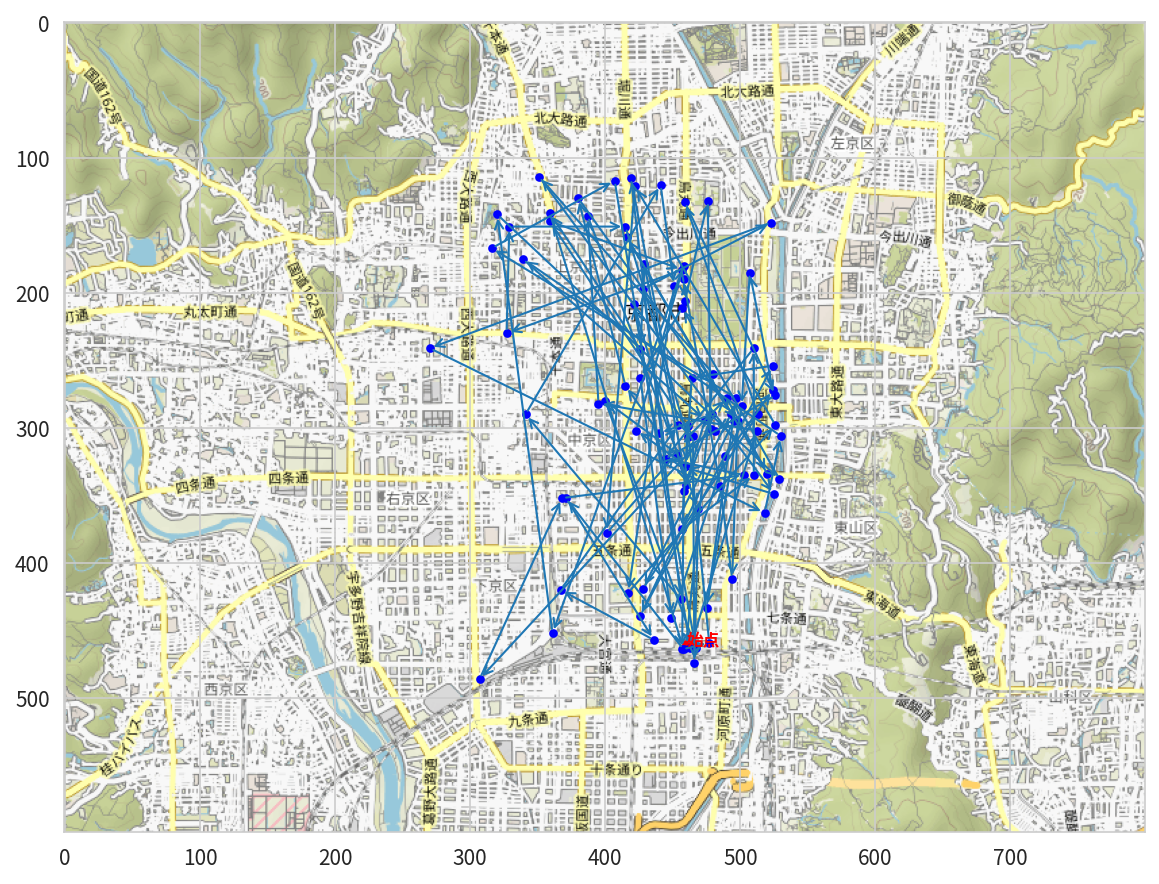

In [150]:
def lon_to_pixel(lon, map):
    # 経度→タイル番号
    if not (-180 <= lon <= 180):
        lon = (lon + 180) % 360 - 180
    x = ((lon + 180.) / 360) * pow(2, map.zoom)
    # タイル番号→キャンバスの座標
    pixel = (x - map.x_center) * map.tile_size + map.width / 2
    return int(round(pixel))


def lat_to_pixel(lat, map):
    # 緯度→タイル番号
    if not (-90 <= lat <= 90):
        lat = (lat + 90) % 180 - 90
    y = (1 - log(tan(lat * pi / 180) + 1 / cos(lat * pi / 180)) / pi) / 2 * pow(2, map.zoom)
    # タイル番号→キャンバスの座標
    pixel = (y - map.y_center) * map.tile_size + map.height / 2
    return int(round(pixel))


def image_map(vis_df, height, width, zoom):
    """サンプリングしたデータで描画する関数

    :param df:
    :param height:
    :param width:
    :return:
    """
    df = vis_df.copy()
    map = StaticMap(height, width)

    BBox = (df["経度"].min(), df["緯度"].min(), df["経度"].max(), df["緯度"].max())
    center_lat = (BBox[1] + BBox[3]) / 2
    center_lng = (BBox[0] + BBox[2]) / 2

    img = map.render(zoom=zoom, center=[center_lng, center_lat])
    df["lat"] = df["緯度"].apply(lambda x: lat_to_pixel(x,map))
    df["lng"] = df["経度"].apply(lambda x: lon_to_pixel(x,map))

    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(df[:1].lng, df[:1].lat, zorder=2, alpha=1, c='r', s=10)
    ax.scatter(df[1:].lng, df[1:].lat, zorder=2, alpha=1, c='b', s=10)

    # plot arrow
    arrow_nodes = [[i,j] for i,j in zip(df.lng, df.lat)]

    ## 道路上を移動する場合、arrowの矢羽をつけたいところとつけたくないところがある。矢羽をつけたいところをis_end=1で表現する
    if 'is_end' in df.columns:
        is_end_list = df['is_end'].values
    else:
        is_end_list = [1]*df.shape[0]

    for i in range(len(arrow_nodes)-1):
        is_end = is_end_list[i+1]
        if is_end:
            arrowstyle = '->'
        else:
            arrowstyle = '-'
        ax.annotate('', xy=arrow_nodes[i+1], xytext=arrow_nodes[i],
        arrowprops=dict(arrowstyle=arrowstyle, connectionstyle='arc3', facecolor='C0', edgecolor='C0'))

    ax.text(df.lng.iat[0], df.lat.iat[0], f'始点', c='r', size=8, weight='bold')
    ax.imshow(img, zorder=0)
    # plt.legend()
    plt.tight_layout()

    plt.show()
    plt.close()

# 総移動距離の算出に関しては、京都駅に戻るルートまで計算させたいので、新規のdfとしておく
_new_df = pd.concat([new_df, station_df]).reset_index(drop=True)
total_distance = calu_total_distance(_new_df)
print(_new_df.shape)
print("総移動距離[km]: {}".format(total_distance))
image_map(new_df, 800, 600, 13)

In [136]:
## 2点間の直線距離を算出してdistance_matrixを作成する
def create_distance_matrix(vis_df):
    df = vis_df.copy()

    distance_matrix = [[999999]*len(df) for i in range(len(df))]
    lats = df['緯度'].values
    lngs = df['経度'].values

    for i in range(len(df)):
        start_pos = lats[i], lngs[i]
        for j in range(len(df)):
            end_pos = lats[j], lngs[j]
            distance = int(geodesic(start_pos, end_pos).m)
            distance_matrix[i][j] = distance

    return distance_matrix

distance_matrix = create_distance_matrix(new_df)
pd.DataFrame(distance_matrix).head()

0     1     2     3     4     5     6     7     8     9   ...    90  \
0     0  3135  5665  2009  2047  4409  3448  5221    73  2191  ...  2393   
1  3135     0  3043  1555  1126  1491   890  2646  3201  2220  ...   784   
2  5665  3043     0  4566  3747  1588  2314   444  5713  3724  ...  3464   
3  2009  1555  4566     0  1095  3043  2278  4150  2082  2406  ...  1199   
4  2047  1126  3747  1095     0  2378  1448  3310  2109  1401  ...   349   

     91    92    93    94    95    96    97    98    99  
0  2879  2183  4749  2708   827  2777  5105  3054  2496  
1   323  1313  1867   509  2600   703  2012   759   644  
2  3361  4334  1236  3534  4898  3743  1708  3721  3560  
3  1232   246  3418  1046  1869   933  3526  1141  1013  
4   940   980  2731   827  1473  1055  3058  1348   558  

[5 rows x 100 columns]

In [151]:
# or-tool
# callback時にdistance_matrixを参照しにいくので、まとめた方が良いかも

num_vehicles = 1
depot = 0


def create_data_model(distance_matrix, num_vehicles, depot):
    data = dict()
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = num_vehicles
    data["depot"] = depot

    return data


def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]


def get_routes(solution, routing, manager):
  """Get vehicle routes from a solution and store them in an array."""
  # Get vehicle routes and store them in a two dimensional array whose
  # i,j entry is the jth location visited by vehicle i along its route.
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes

data = create_data_model(distance_matrix, num_vehicles, depot)

manager = pywrapcp.RoutingIndexManager(
    len(data['distance_matrix']),
    data['num_vehicles'],
    data['depot']
)

routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    routes = get_routes(solution, routing, manager)[0]
    print(routes)

[0, 78, 24, 83, 51, 74, 32, 53, 82, 49, 26, 4, 61, 22, 41, 56, 62, 28, 12, 52, 90, 84, 70, 33, 40, 54, 45, 3, 66, 92, 46, 19, 98, 71, 59, 55, 96, 79, 31, 57, 99, 37, 48, 27, 94, 73, 75, 91, 1, 60, 67, 35, 17, 34, 86, 63, 72, 43, 36, 97, 16, 20, 13, 77, 30, 2, 65, 88, 76, 44, 87, 47, 85, 7, 81, 89, 93, 5, 42, 25, 6, 68, 29, 23, 80, 15, 39, 9, 21, 11, 38, 64, 58, 18, 95, 14, 69, 10, 50, 8, 0]


総移動距離[km]: 34.387055123068095


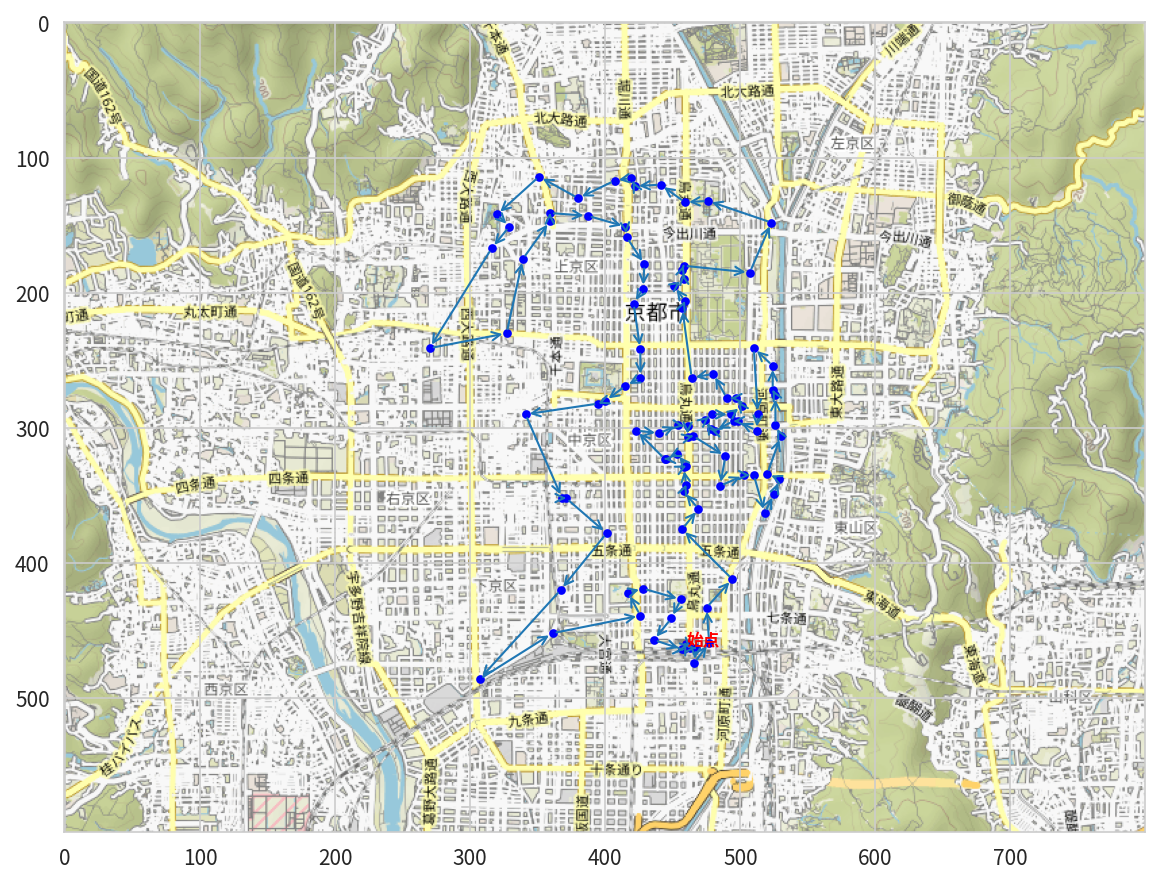

In [152]:
opt_df = new_df.reindex(routes).reset_index(drop=True)
opt_total_distance = calu_total_distance(opt_df)
print("総移動距離[km]: {}".format(opt_total_distance))
image_map(opt_df, 800, 600, 13)

In [140]:
## 終点を固定することも可能
data["starts"] = [0]
data["ends"] = [99]
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]),
    data["num_vehicles"],
    data["starts"],
    data["ends"]
)

routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    routes = get_routes(solution, routing, manager)[0]
    print(routes)

[0, 50, 8, 83, 78, 24, 51, 74, 32, 14, 69, 10, 58, 95, 18, 64, 38, 11, 21, 9, 39, 15, 80, 23, 29, 68, 6, 25, 42, 67, 35, 17, 34, 86, 63, 5, 93, 89, 81, 7, 85, 47, 87, 44, 76, 88, 65, 2, 30, 77, 13, 20, 16, 97, 36, 43, 72, 55, 59, 71, 98, 96, 79, 19, 46, 92, 66, 3, 45, 54, 40, 70, 33, 82, 53, 49, 26, 4, 61, 22, 41, 56, 62, 28, 12, 90, 84, 52, 60, 1, 91, 75, 73, 31, 57, 94, 27, 48, 37, 99]


総移動距離[km]: 33.44721419783613


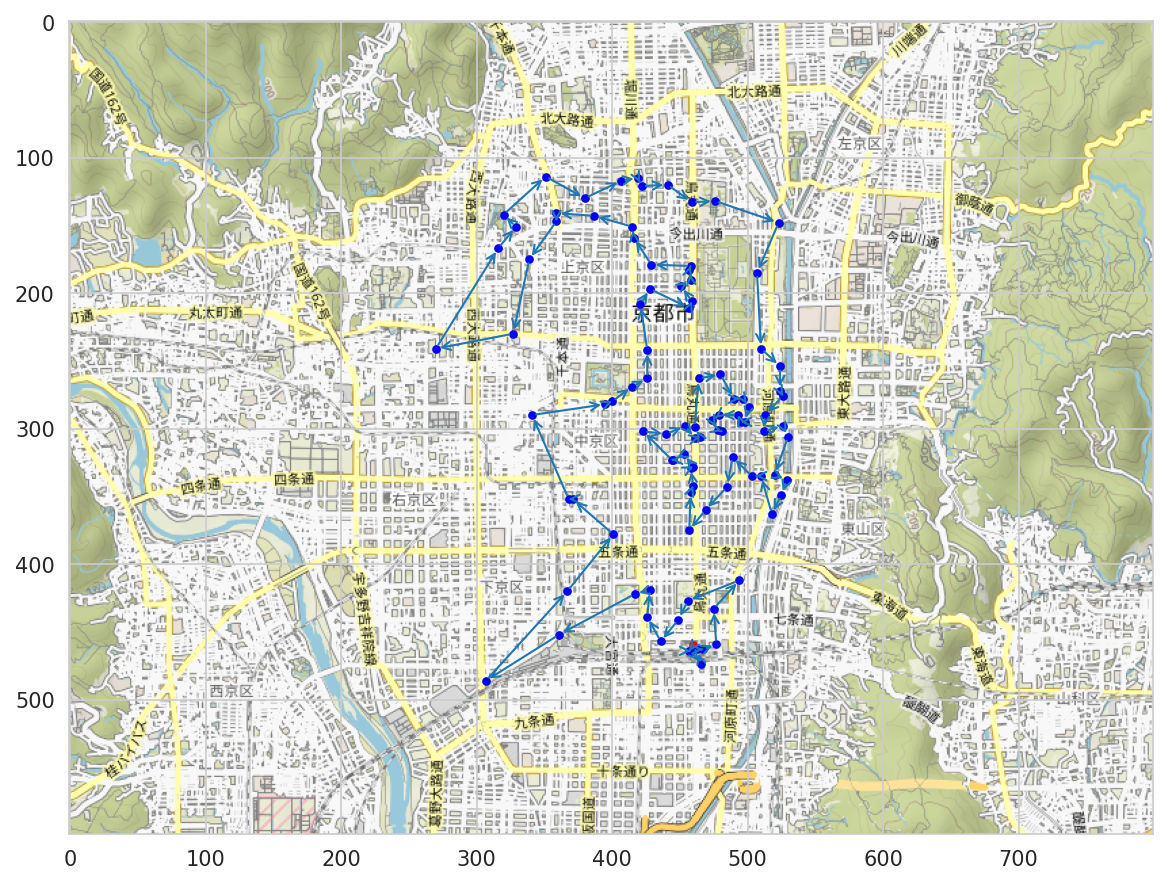

In [141]:
opt_df2 = new_df.reindex(routes).reset_index(drop=True)
opt_total_distance2 = calu_total_distance(opt_df2)
print("総移動距離[km]: {}".format(opt_total_distance2))
image_map(opt_df2, 800, 600, 13)